# **METAMODELING WITH ARTIFICIAL NEURAL NETWORK**

In this notebook, we will use the results of Abaqus analyses in order to build an Artificial Neural Network (ANN) of the Finite Element (FE) analysis solver.

In [1]:
# Install latest Tensorflow build
#!pip install -q tf-nightly-2.0-preview
from tensorflow import summary
%load_ext tensorboard

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import time
import sys
import os

In [62]:
# Scikit-learn
from sklearn.model_selection import train_test_split

# PyTorch
import torch
import torch.utils.data as Data
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.tensorboard import SummaryWriter

# Pyrenn
! pip install pyrenn
import pyrenn as prn

# Matplotlib spec
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']}) # Palatino font
plt.rcParams['pdf.fonttype'] = 42

In [4]:
torch.__version__

'1.5.0'

When this notebook has been generated the result of the previous line of code is: _'1.5.1+cu101'_

We fix the seed in order to obtain reproducible results.

__N.B.__ : Reproducible results are obtained every time the runtime is restarded and runned. If you run multiple time the same cell the results will not be reporducible.

In [5]:
seed = 0
np.random.seed(seed=seed)
torch.manual_seed(seed=seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.cuda.manual_seed(seed=seed)

## **Data preprocessing**

We start by importing some information about the model used to generate the dataset.

In [7]:
# Modify parameter to choose the output folder to consider
stacking_sequence = 'symmetric'
data_set = 'large1.65'
load_case = 'torsion'
fiber_path = 'harmlin'

# Check if notebook running in Colab
is_colab = 'google.colab' in sys.modules

# Model info folder
input_folder = './'

info = pd.read_csv(input_folder + 'model_info.csv', sep=";")
info.index = ['Value']
eff_plies = int(info['EffectivePlies'].values)
info.head()

,Height,Radius,MaxCurvature,MeshSize,Plies,EffectivePlies,Symmetric,Balanced,AnglesFunction,LoadCase,Train,Val,Test
Value,705,300,0.001575,5,8,2,True,True,harmlin,axial,81,27,27


In [17]:
sets = ['Train', 'Val', 'Test']
for set in sets:
    if set not in info.keys():
        sets.remove(set)

At this point we have to import the data set containing the input and output of the FE analysis. The data is stored in a dataframe in which the upper part is associated to the training set and the lower part to the test set. The precise number of upper row belonging to the train set is indicated in the info above.

In [26]:
# Data folder
data_folder = './'

data_orig = pd.read_csv(data_folder + '/data.csv', sep=';')
data = data_orig.drop(columns='Stiffness')
data_orig

,Amplitude1,PhaseShift1,Omega1,Beta1,Amplitude2,PhaseShift2,Omega2,Beta2,Buckling,Stiffness
0,65.08,20.60,0.39,38.52,14.60,76.85,1.27,13.29,235.051,281175.0
1,24.39,85.65,1.72,7.86,46.78,69.20,0.66,27.25,239.225,388831.0
2,19.29,45.21,1.29,8.63,87.30,76.00,0.53,2.56,190.754,465806.0
3,65.79,62.30,0.25,2.35,20.34,16.69,1.16,19.37,182.235,448824.0
4,13.92,28.67,0.07,26.28,57.23,84.57,0.48,20.18,248.555,365717.0
...,...,...,...,...,...,...,...,...,...,...
130,73.83,10.10,0.30,15.26,19.30,48.92,1.81,7.24,225.731,421545.0
131,33.20,6.00,1.23,36.61,94.59,58.90,0.23,26.93,225.708,194835.0
132,33.40,23.11,0.11,7.64,42.03,76.21,0.85,17.11,178.640,452326.0
133,23.20,25.50,0.49,32.97,84.96,32.20,0.18,9.29,243.416,322473.0


The most important step to perform before training our model is the normalization of the variables. Different strategies are possible at this end, among which 2 are the most used:

* Range normalization: converts all the values to the range $[0, 1]$

* Standard score normalization: forces the variables to have $0$ mean and $1$ standard deviation

We will try both to see the effect on the model performance.

In [27]:
def range_norm(x):
    """normalization in range [0, 1]"""
    x_min = np.min(x, axis=0)
    x_max = np.max(x, axis=0)
    x_norm = (x - x_min) / (x_max - x_min)

    return x_norm

def std_norm(x):
    """normalization with zero mean and unitary standard deviation"""
    m = np.mean(x, axis=0)
    s = np.std(x, axis=0)
    x_norm = (x - m) / s
    
    return x_norm

In [28]:
data_norm = range_norm(data_orig)
data_norm.describe()

,Amplitude1,PhaseShift1,Omega1,Beta1,Amplitude2,PhaseShift2,Omega2,Beta2,Buckling,Stiffness
count,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000
mean,0.503193,0.501657,0.342395,0.497512,0.500112,0.502561,0.366686,0.502270,0.495412,0.510102
std,0.293347,0.293968,0.256763,0.293973,0.295692,0.293923,0.262649,0.292343,0.216112,0.258279
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.257680,0.250901,0.147208,0.248591,0.243842,0.251185,0.154450,0.256666,0.369555,0.285821
50%,0.503545,0.498198,0.274112,0.500563,0.501305,0.511515,0.324607,0.502129,0.505081,0.523821
75%,0.750760,0.753660,0.497462,0.745436,0.748326,0.757507,0.528796,0.750168,0.633420,0.712391
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now we can split the data into training and test set. The two sets have been generate independently during the DOE.

In [59]:
X = data_norm.drop(['Buckling', 'Stiffness'], axis=1).values
Y = data_norm[['Buckling','Stiffness']].values

# Train set
train_smp = int(info['Train'].values)
X_train = X[:train_smp, :]
Y_train = Y[:train_smp]
last = np.copy(train_smp)

# Validation set
if 'Val' in sets:
    val_smp = int(info['Val'].values)
    X_val = X[last:last+val_smp, :]
    Y_val = Y[last:last+val_smp]
    last += val_smp

# Test set
if 'Test' in sets:
    test_smp = int(info['Test'].values)
    X_test = X[last:last+test_smp, :]
    Y_test = Y[last:last+test_smp]

print('             - - - - - - - ')
print('            |Problem info:|')
print('             - - - - - - -  \n')
print("X_train : {}  |  Y_train : {}".format(X_train.shape, Y_train.shape))
print("X_val   : {}  |  Y_val   : {}".format(X_val.shape, Y_val.shape))
print("X_test  : {}  |  Y_test  : {} \n".format(X_test.shape, Y_test.shape))


             - - - - - - - 
            |Problem info:|
             - - - - - - -  

X_train : (81, 8)  |  Y_train : (81, 2)
X_val   : (27, 8)  |  Y_val   : (27, 2)
X_test  : (27, 8)  |  Y_test  : (27, 2) 



At this point we can generate the iterable data sets for Torch

In [168]:
# just for the training set
batch = 32

def _init_fn(worker_id):
    np.random.seed(int(seed))
    
train_dataset = Data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).float())
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=batch, shuffle=True, num_workers=0, worker_init_fn=_init_fn)

val_dataset = Data.TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(Y_val).float())
val_loader = Data.DataLoader(dataset=val_dataset, batch_size=X_val.shape[0], shuffle=True, num_workers=0,  worker_init_fn=_init_fn)

test_dataset = Data.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(Y_test).float())
test_loader = Data.DataLoader(dataset=test_dataset, batch_size=X_test.shape[0], shuffle=True, num_workers=0, worker_init_fn=_init_fn)

## **Neural network**

First define network class

In [192]:
class MLPNN(torch.nn.Module):

    def __init__(self, D_in, H, D_out):
        super(MLPNN, self).__init__()
        # First hidden layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(H, D_in)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(H), 0))
        # Second hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(H, H)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(H), 0))
        # Third hidden layer
        self.W_3 = Parameter(init.xavier_normal_(torch.Tensor(H, H)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(H), 0))
        # Output layer
        self.W_4 = Parameter(init.xavier_normal_(torch.Tensor(D_out, H)))
        self.b_4 = Parameter(init.constant_(torch.Tensor(D_out), 0))
        
        # define activation function in constructor
        self.activation_1 = torch.nn.ReLU()
        self.activation_2 = torch.nn.ReLU()
        self.activation_3 = torch.nn.ReLU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation_1(x)
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation_2(x)
        x = F.linear(x, self.W_3, self.b_3)
        x = self.activation_3(x)
        pred = F.linear(x, self.W_4, self.b_4)
        return pred

In [170]:
# Lambda function to generate mini-batches
get_batch = lambda i, size: range(i * size, (i + 1) * size)

In [190]:
n_x = X_train.shape[1]
n_y = Y_train.shape[1]
D_in, H, D_out = n_x, 4, n_y

modelMLP = MLPNN(D_in, H, D_out)

epochs = 10000
lr = 1e-2

# Flag True if you are in the network optimization process
is_optimizing = True

# If weight_NN exists and we are not in optimization mode just load
# network weights and evaluate the model.
if(os.path.isfile('net_weights/weights_NN') and is_optimizing==False):
    modelMLP.load_state_dict(torch.load('net_weights/weights_NN'))
    print(modelMLP.eval())
else:
    criterion = nn.MSELoss(reduction='mean') 
    optimizer = optim.Adam(modelMLP.parameters(), lr=lr, weight_decay=1e-6)
    
    # Initialize loss lists.
    train_loss = []
    val_loss = []
    test_loss = []
    losses = []
    curr_loss = 0
    
    for epoch in range(epochs):
        
        modelMLP.train()
        for step, (batch_x, batch_y) in enumerate(train_loader):
            y_pred = modelMLP(batch_x)
            
            
            batch_loss = criterion(y_pred, batch_y)
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            
            curr_loss += batch_loss
            
        train_loss.append(batch_loss.item() / step)

        modelMLP.eval()
        
        for _, (val_x, val_y) in enumerate(val_loader):
            val_pred = modelMLP(val_x)
            loss_val = criterion(val_pred, val_y)
            
        val_loss.append(loss_val.item())

        if epoch % 100 == 0:
            print("Iteration : {} | Train loss : {:.5f} | Val loss : {:.5f}".format(epoch, train_loss[epoch], val_loss[epoch]))

    torch.save(modelMLP.state_dict(), 'weights_NN')

tb.add_graph(modelMLP, batch_x)
tb.close()

Iteration : 0 | Train loss : 0.04220 | Val loss : 0.09654
Iteration : 100 | Train loss : 0.00837 | Val loss : 0.02631
Iteration : 200 | Train loss : 0.00355 | Val loss : 0.02465
Iteration : 300 | Train loss : 0.00747 | Val loss : 0.02560
Iteration : 400 | Train loss : 0.00439 | Val loss : 0.02708
Iteration : 500 | Train loss : 0.00572 | Val loss : 0.02715
Iteration : 600 | Train loss : 0.00840 | Val loss : 0.02824
Iteration : 700 | Train loss : 0.00595 | Val loss : 0.03039
Iteration : 800 | Train loss : 0.00625 | Val loss : 0.02844
Iteration : 900 | Train loss : 0.00595 | Val loss : 0.03126
Iteration : 1000 | Train loss : 0.00408 | Val loss : 0.03026
Iteration : 1100 | Train loss : 0.00573 | Val loss : 0.03032
Iteration : 1200 | Train loss : 0.00438 | Val loss : 0.02997
Iteration : 1300 | Train loss : 0.00395 | Val loss : 0.02993
Iteration : 1400 | Train loss : 0.00604 | Val loss : 0.02894
Iteration : 1500 | Train loss : 0.00429 | Val loss : 0.03053
Iteration : 1600 | Train loss : 0.00

(-0.0, 0.2)

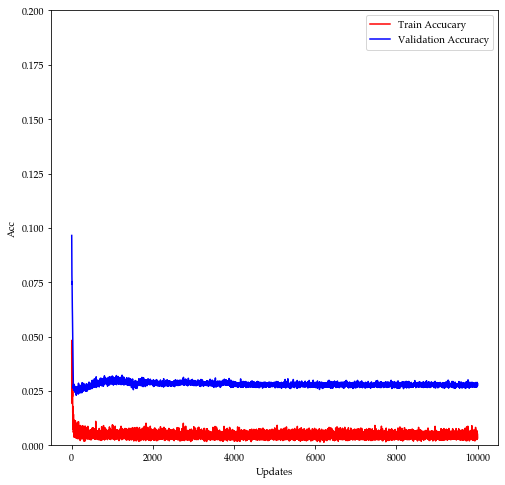

In [191]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(epochs), train_loss, 'r', np.arange(epochs), val_loss, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')
plt.ylim(-.0, .2)

In [183]:
modelMLP.eval()
for _, (test_x, test_y) in enumerate(test_loader):
    test_pred = modelMLP(test_x)
    for i in range(test_y.shape[0]):
        err_perc = (test_y.numpy() - test_pred.detach().numpy()) / test_y.numpy() * 100
        print("True : {:.4f}, {:.4f}  |  Prediction : {:.4f}, {:.4f}  |  Error : {:07.2f}%, {:07.2f}%".
              format(*test_y[i, :].numpy(), *test_pred[i, :].detach().numpy(), *err_perc[i, :]))

True : 0.6952, 0.6050  |  Prediction : 0.5091, 0.6306  |  Error : 0026.77%, -004.22%
True : 0.7150, 0.6589  |  Prediction : 0.5231, 0.6586  |  Error : 0026.84%, 0000.05%
True : 0.0608, 0.8413  |  Prediction : 0.1165, 0.8364  |  Error : -091.68%, 0000.58%
True : 0.3848, 0.7040  |  Prediction : 0.2339, 0.8264  |  Error : 0039.22%, -017.39%
True : 0.1405, 0.8262  |  Prediction : 0.3894, 0.7837  |  Error : -177.14%, 0005.14%
True : 0.4991, 0.2266  |  Prediction : 0.5337, 0.2596  |  Error : -006.94%, -014.59%
True : 0.4369, 0.6837  |  Prediction : 0.5098, 0.5826  |  Error : -016.67%, 0014.78%
True : 0.2431, 0.6512  |  Prediction : 0.2136, 0.7444  |  Error : 0012.12%, -014.30%
True : 0.6432, 0.2436  |  Prediction : 0.5322, 0.2034  |  Error : 0017.26%, 0016.51%
True : 0.4795, 0.2499  |  Prediction : 0.5651, 0.2846  |  Error : -017.84%, -013.90%
True : 0.5915, 0.2097  |  Prediction : 0.5999, 0.2321  |  Error : -001.42%, -010.68%
True : 0.6205, 0.7150  |  Prediction : 0.2957, 0.8303  |  Error :

In [17]:
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 258), started 4:47:33 ago. (Use '!kill 258' to kill it.)

<IPython.core.display.Javascript object>

In [40]:
class EarlyStopping:
    def __init__(self, patience=30, delta=1e-3, path='checkpoint.pt'):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        if self.val_loss_min > val_loss:
            self.val_loss_min = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True